In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Product image background generation with Gemini 1.5 Pro and Imagen 2

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retail/product_image_background_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fretail%2Fproduct_image_background_generation.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retail/product_image_background_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retail/product_image_background_generation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Katie Nguyen](https://github.com/katiemn) |

## Overview

### Gemini 1.5 Pro

Gemini 1.5 Pro is a new language model from the Gemini family. This model introduces a long context window of up to 1 million tokens that can seamlessly analyze large amounts of information. Additionally, it is multimodal with the ability to process text, images, audio, video, and code. Learn more about [Gemini 1.5](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024/).

### Imagen 2

Imagen 2 on Vertex AI brings Google's state of the art generative AI capabilities to application developers. With Imagen 2 on Vertex AI, application developers can build next-generation AI products that transform their user's imagination into high quality visual assets. Learn more about [Imagen on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview).


In this tutorial, you will learn how to use the Vertex AI SDK for Python to interact with the Gemini 1.5 Pro model and certain Imagen 2 image editing features to:

- Upload an image for an e-commerce product listing
- Generate a product description
- Enhance the background of a product image

## Getting Started


### Install Vertex AI SDK for Python


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment.


In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
from vertexai.generative_models import GenerativeModel, Image, Part

### Load the Gemini 1.5 Pro model


In [ ]:
model = GenerativeModel("gemini-1.5-pro")

### Define helper functions

In [ ]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(
    image: Image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def get_url_from_gcs(gcs_uri: str) -> str:
    # Converts GCS uri to url for image display
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url

### Download a sample product image from Google Cloud Storage

Use the ```Part.from_uri``` method to load a file as the example product image.


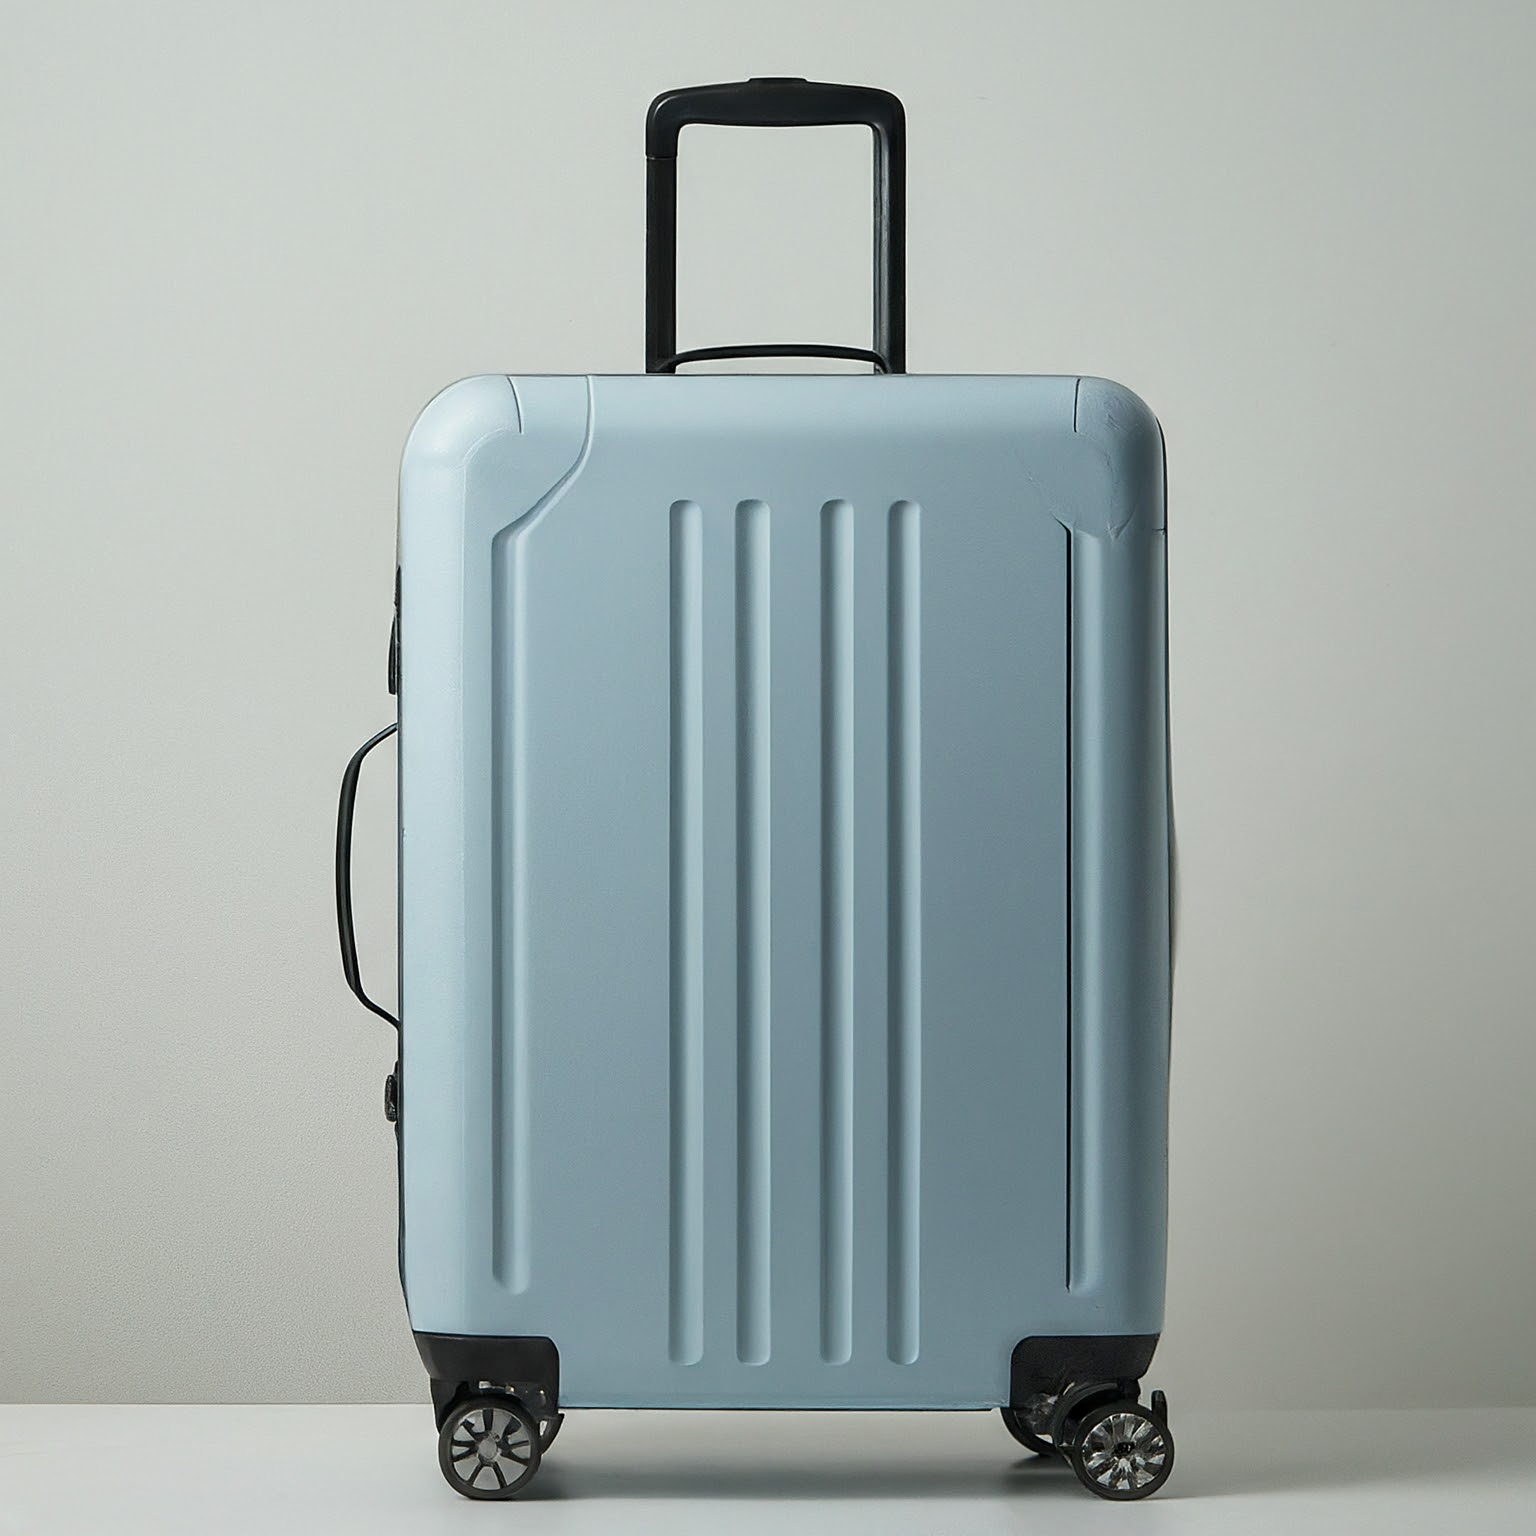

In [ ]:
# Load an image from Google Cloud Storage
gcs_uri = "gs://cloud-samples-data/generative-ai/image/suitcase.png"
product_image = Part.from_uri(gcs_uri, mime_type="image/png")

# Display image
url = get_url_from_gcs(product_image.file_data.file_uri)
IPython.display.Image(url, width=350)

### Upload a sample product image from a local file (optional)
Use the ```Image.load_from_file``` method to use your own image that you can upload to the runtime environment.

 Uncomment the following cell, and replace "image.png" with the name of your image file.

In [ ]:
# # Load from local file
# image_name = "image.png" # @param {type:"string"}
# product_image = Image.load_from_file(image_name)

# # Display image
# display_image(product_image)

### Generate image prompt

Use Gemini 1.5 Pro to generate a text prompt based on the provided product metadata and initial image.

In [ ]:
# Update the product description if using a different image
product_description = "a blue suitcase with wheels"  # @param {type:"string"}

prompt = """
Create a description of the product image.

The description should be an image generation prompt to create a more interesting background.

Only return the prompt string.
"""

contents = [product_image, product_description, prompt]

responses = model.generate_content(contents)
description = responses.text
print(description)

a blue suitcase with wheels on a cobblestone street with the eiffel tower in the background and a hot air balloon in the sky  



### Import libraries

In [ ]:
from vertexai.preview.vision_models import Image as VisionImage
from vertexai.preview.vision_models import ImageGenerationModel

### Load the image generation model

In [ ]:
generation_model = ImageGenerationModel.from_pretrained("imagegeneration@006")

### Generate a new product image

Use the ```edit_image``` function to enhance the product image by modifying the background content while preserving the product appearance.

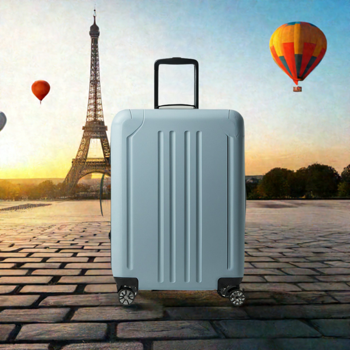

In [ ]:
output_file = "image_enhanced.png"
input_file = VisionImage(get_image_bytes_from_url(url))

# Uncomment and replace image name if using your own example
# image_name = "image.png" # @param {type:"string"}
# input_file = VisionImage.load_from_file(image_name)

gen_img = generation_model.edit_image(
    base_image=input_file,
    prompt=description,
    edit_mode="product-image",
)

display_image(gen_img.images[0])
gen_img.images[0].save(output_file)